In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

This code is to show how the black-box variational inference with $\textbf{time-independent}$ OU processes work under the observations from OU processes. Here, we deliberately initiated the underlying OU processes on high value so that it generates a sequence of observations converging toward its mean, i.e. 0. As our variatioanl process is suitable for observations tending toward their mean, we expect the resulting posterior process looks similar to the underlying SDE.

Note that this version is $\textbf{equivalent as the one presented in Archambeau et al 2007}$ in that both uses $\textbf{time-homogeneous}$ OU processes to approximate posterior process arisen from OU processes $\textbf{at each time interval}$. The difference arises from that while we use one OU process for one observational time interval, Archabeau uses one OU process for one time-grid, which is much finer than the observational time interval.

**Class: OU processes**

In [2]:
class OU:
    def __init__(self, t0, t1, z0, alpha, beta, sigma, dN):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
        """
        output = np.empty(len(self.pts))
        output[0] = self.z0
        interval = self.pts[1:] - self.pts[:-1]
        for t in range(1, len(self.pts)):
            
            # if the distance is too small, variance becomes 0
            dt = interval[t-1]
            
            mean = self.alpha + (output[t-1] - self.alpha) * np.exp(-1 * self.beta * dt)
            var = np.sqrt((self.sigma ** 2) * (1 - np.exp(-2 * self.beta * dt)) / (2 * self.beta))
            assert var > 0, "variance is negative, var:%.3f interval: %.3f" % (var, dt)
            output[t] = ss.norm.rvs(loc = mean, scale = var)
        return torch.from_numpy(output), interval

Variational inference: KL

In [3]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha, self.beta, self.sigma = torch.tensor([ou.alpha, ou.beta, ou.sigma])
        
    def KL_ito(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma = self.alpha, self.beta, self.sigma

        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        func_kl = vmap(lambda z: z ** 2)
        return ((beta ** 2) - 1 ) / 2  * torch.trapezoid(abs(func_kl(self.ou.trj)), x=self.ou.pts)
    
    def KL_rest(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma = self.alpha, self.beta, self.sigma
        z0 = self.ou.z0
        z1 = self.ou.trj[-1]
        t0 = self.ou.t0
        t1 = self.ou.t1
        
        # Obtain the rest 
        def A(u):
            return (u ** 2) / 2
        
        return (1 + beta) * (A(z1) - A(z0) - ((t1 - t0) / 2))
    
    def log_prob(self, obs):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
        """
        def log_pdf(obs, z):
            return ss.norm.logpdf(obs, loc=z, scale=.001)
            
        
        return log_pdf(obs, self.ou.trj[-1])


In [12]:
class Score:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, alpha, beta):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        beta = Variable(beta, requires_grad = True)
        alpha = Variable(alpha, requires_grad = True)
        sigma = torch.tensor(self.ou.sigma)
        dt = self.ou.dt
        X = self.ou.trj
        
        def compute_transition(X, dt, alpha, beta, sigma):
            """
            Compute the transition density of the (simulated) path
            """
            term1 = -1/2 * (2 * torch.log(sigma) - torch.log(beta) + torch.log(1 - torch.exp(-2 * beta * dt)))
            term2 = -1 * beta * (X[1:] - alpha - (X[:-1] - alpha) * torch.exp(-1 * beta * dt)) ** 2 
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * beta * dt))

            return torch.sum(term1 + term2/term3)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma)
        
        NLL.backward()
         
        return {'beta':beta.grad.detach().clone(), 'alpha':alpha.grad.detach().clone()}


**Generate observations from Gaussian likelihood**

Noisy Observations from the SDE:

$dX_{t} = -X_{t}dt + \sigma dW_{t}$

In [5]:
true_sde = OU(t0 = 0, t1 = 6., z0 = 10, alpha = 0, beta = 1., sigma = 1., dN=1000)

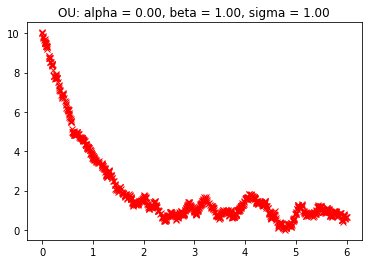

In [6]:
plt.plot(true_sde.pts, true_sde.trj, 'rx')
plt.title("OU: alpha = %.2f" % true_sde.alpha + ", beta = %.2f" % true_sde.beta + ", sigma = %.2f" % true_sde.sigma)
plt.show()

In [7]:
obs = np.random.normal(loc = true_sde.trj[::100], scale = .001)
obs_time = true_sde.pts[::100]

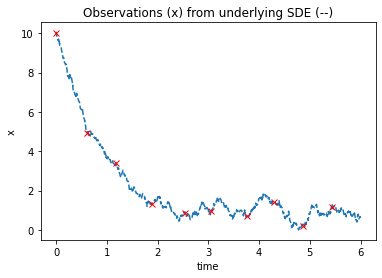

In [8]:
plt.title("Observations (x) from underlying SDE (--)")
plt.plot(true_sde.pts, true_sde.trj, '--')
plt.plot(true_sde.pts[::100], obs, 'rx')
plt.xlabel("time")
plt.ylabel("x")
plt.show()

**Variational inference: a piece-wise approximation**

1. one-time variational inference from t=0 to t=1

In [9]:
import tqdm as tq

In [18]:
beta_ = 5.
alpha_ = 2.

N = 50
N_e = 50
learning_rate = 0.0000001
IT = 300

trace_pars = np.empty((2, IT))
trace_elbo = []
for k in tq.tqdm(range(IT)):
    beta_grad = 0.
    alpha_grad = 0.

    for i in range(N):
        vi = OU(t0 = obs_time[0], t1 = obs_time[1], z0 = obs[0], alpha = alpha_ , beta = beta_ , sigma = 1., dN=20)
        elbo = ELBO(vi)
        score = Score(vi)
        
        scores = score.compute_score(torch.tensor(alpha_, dtype=torch.float64), torch.tensor(beta_, dtype=torch.float64))
        f_of_X = -1 * (elbo.log_prob(obs[1]) + elbo.KL_ito() + elbo.KL_rest())
        beta_grad += f_of_X * scores['beta']
        alpha_grad += f_of_X * scores['alpha']
     
    beta_ -= learning_rate * (beta_grad/N).numpy()
    alpha_-= learning_rate * (alpha_grad/N).numpy()

    elbo_estimate = 0
    for j in range(N_e):
        vi_ = OU(t0 = obs_time[0], t1=obs_time[1], z0 = obs[0], alpha = alpha_ , beta = beta_ , sigma = 1., dN=20)
        elbo_ = ELBO(vi_)
        elbo_estimate += -1 * (elbo_.log_prob(obs[1]) + elbo_.KL_ito() + elbo_.KL_rest())
    
    elbo_estimate *= 1/N_e
    
    trace_pars[0,k] = alpha_
    trace_pars[1,k] = beta_
    trace_elbo.append(elbo_estimate)
# score.compute_score()

100%|█████████████████████████████████████████| 300/300 [00:59<00:00,  5.03it/s]


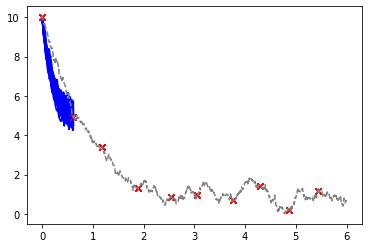

In [19]:
for i in range(50):
    posterior = OU(t0 = obs_time[0], t1 = obs_time[1], z0 = obs[0], alpha = alpha_ , beta = beta_ , sigma = 1., dN=100)
    plt.plot(posterior.pts, posterior.trj, 'b')
    plt.plot(obs_time, obs, 'rx')
plt.plot(true_sde.pts,true_sde.trj, 'grey', linestyle='dashed')

**Trace plot: gradient**

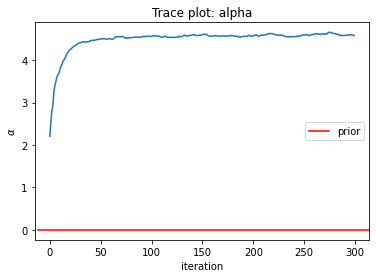

In [20]:
plt.title("Trace plot: alpha")
plt.plot(np.arange(len(trace_pars[0])), trace_pars[0])
plt.axhline(true_sde.alpha, xmin=0.01, xmax=300, color='red', label='prior')
plt.legend()
plt.xlabel("iteration")
plt.ylabel(r"$\alpha$")
plt.show()

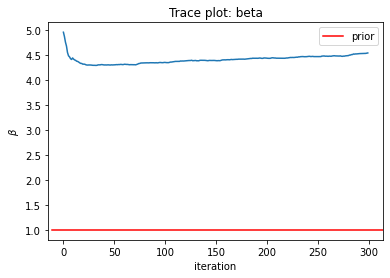

In [21]:
plt.title("Trace plot: beta")
plt.plot(np.arange(len(trace_pars[1])), trace_pars[1])
plt.axhline(true_sde.beta, xmin=0.01, xmax=300, color='red', label='prior')
plt.legend()
plt.xlabel("iteration")
plt.ylabel(r"$\beta$")
plt.show()

Trace plot: ELBO

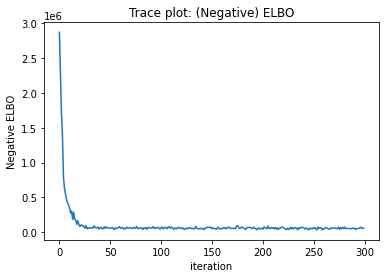

In [22]:
plt.title("Trace plot: (Negative) ELBO")
plt.plot(np.arange(len(trace_elbo)), trace_elbo)
plt.xlabel("iteration")
plt.ylabel("Negative ELBO")
plt.show()

**Posterior moment based on the average of last 30 iterations of beta**

In [23]:
def posterior_moment(init, alpha, beta):
    sigma = 1.
    pts = np.linspace(0,1,100)
    dt = pts[1:] - pts[:-1]
    
    mean = [init]
        
    for i in range(dt.shape[0]):
        mean.append(alpha + (mean[i] - alpha)*np.exp(-1 * beta * dt[i]))
    
    func = lambda t: np.sqrt((sigma ** 2 / (2*beta)) * (1 - np.exp(-2 * beta * t)))
    sd = list(map(func, dt))
    
    return np.array(mean), np.array(sd)

In [24]:
pmean, psd = posterior_moment(obs[0], alpha_, beta_)

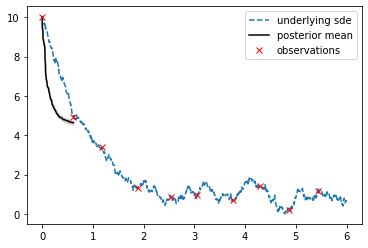

In [25]:
plt.plot(true_sde.pts, true_sde.trj, linestyle='dashed', label='underlying sde')
plt.plot(true_sde.pts[:100], pmean, 'black', label='posterior mean')
plt.fill_between(true_sde.pts[1:100], pmean[1:] - psd, pmean[1:] + psd, alpha=0.3, color='grey')
plt.plot(obs_time, obs, 'rx', label='observations')
plt.legend()
plt.show()

2. Complete piece-wise optimization from t=0 to t=10

We use the posterior mean of the previous step as our initial value for next vi

In [34]:
N = 50
N_e = 50
learning_rate = 0.000001
z0 = obs[0]

vi_pars = np.empty((2,9))

IT = 300

elbo_traces = np.empty((9, IT))
pars_traces = np.empty((2, 9, IT))

for t in tq.tqdm(range(obs.shape[0]-1)):
    beta_ = np.random.uniform(3, 6)
    alpha_ = np.random.uniform(1, 2)
    trace = []
    for i in range(IT):
        beta_grad = 0.
        alpha_grad = 0.
        for k in range(N):
            vi = OU(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0, alpha = alpha_ , beta = beta_ , sigma = 1., dN=30)
            elbo = ELBO(vi)
            score = Score(vi)

            scores = score.compute_score(torch.tensor(alpha_, dtype=torch.float64), torch.tensor(beta_, dtype=torch.float64))
            f_of_X = -1 * (elbo.log_prob(obs[t+1]) + elbo.KL_ito() + elbo.KL_rest())
            
            beta_grad += f_of_X * scores['beta']
            alpha_grad += f_of_X * scores['alpha']

        beta_ -= learning_rate * (beta_grad/N).numpy()
        alpha_-= learning_rate * (alpha_grad/N).numpy()
        pars_traces[1, t, i] = beta_
        pars_traces[0, t, i] = alpha_
        
        elbo_estimate = 0
        for j in range(N_e):
            vi_ = OU(t0 = obs_time[t], t1=obs_time[t+1], z0 = z0, alpha = alpha_ , beta = beta_ , sigma = 1., dN=30)
            elbo_ = ELBO(vi_)
            elbo_estimate += -1 * (elbo_.log_prob(obs[t+1]) + elbo_.KL_ito() + elbo_.KL_rest())
    
        elbo_estimate *= 1/N_e
        if i % 50 == 0:
            print("alpha = ", alpha_, "beta = ", beta_, "elbo = ", elbo_estimate)
        elbo_traces[t, i] = elbo_estimate
    
    vi_pars[0, t] = np.mean(pars_traces[0, t, -30:])
    vi_pars[1, t] = np.mean(pars_traces[1, t, -30:])
    
    z0 *= np.exp(-1 * vi_pars[1, t] * (obs_time[t+1] - obs_time[t]))
    
# score.compute_score()

  0%|                                                     | 0/9 [00:00<?, ?it/s]

alpha =  4.487913231278279 beta =  1.4916001577218427 elbo =  tensor(1783410.6139, dtype=torch.float64)
alpha =  4.6780752771522325 beta =  4.608661245400117 elbo =  tensor(77195.2308, dtype=torch.float64)
alpha =  4.845197875622211 beta =  5.272899720538859 elbo =  tensor(53914.9589, dtype=torch.float64)
alpha =  4.761262051087993 beta =  5.929580199835305 elbo =  tensor(47671.7913, dtype=torch.float64)
alpha =  4.747851445318908 beta =  6.207687536233283 elbo =  tensor(41559.7044, dtype=torch.float64)
alpha =  4.858521241064802 beta =  6.621773438991736 elbo =  tensor(48059.8057, dtype=torch.float64)


 11%|█████                                        | 1/9 [01:22<11:01, 82.72s/it]

alpha =  3.393693537832329 beta =  3.7518557711163862 elbo =  tensor(117245.3173, dtype=torch.float64)
alpha =  3.6103306207062467 beta =  4.480765134681226 elbo =  tensor(50314.0389, dtype=torch.float64)
alpha =  3.5893275181454167 beta =  4.968200811255003 elbo =  tensor(55092.6460, dtype=torch.float64)
alpha =  3.6086764339551918 beta =  5.355885325892201 elbo =  tensor(31135.8362, dtype=torch.float64)
alpha =  3.3235024741990324 beta =  5.717605293763827 elbo =  tensor(53928.5335, dtype=torch.float64)
alpha =  3.5110360724027925 beta =  6.158692484680842 elbo =  tensor(43388.5268, dtype=torch.float64)


 22%|██████████                                   | 2/9 [02:45<09:39, 82.73s/it]

alpha =  1.5208120433116015 beta =  4.245080685510591 elbo =  tensor(46924.9204, dtype=torch.float64)
alpha =  1.335972539145878 beta =  4.825339594546256 elbo =  tensor(53168.3194, dtype=torch.float64)
alpha =  1.1940998167035537 beta =  5.337818005022913 elbo =  tensor(58002.7896, dtype=torch.float64)
alpha =  1.4443935071620901 beta =  5.768904965198295 elbo =  tensor(43262.0394, dtype=torch.float64)
alpha =  1.4330110182534481 beta =  6.079821992417285 elbo =  tensor(47815.7307, dtype=torch.float64)
alpha =  1.4113029872401883 beta =  6.402459289517374 elbo =  tensor(39835.7561, dtype=torch.float64)


 33%|███████████████                              | 3/9 [04:08<08:15, 82.65s/it]

alpha =  0.5974829124076779 beta =  5.799700885802233 elbo =  tensor(83162.8116, dtype=torch.float64)
alpha =  0.9838024168946142 beta =  6.153410116799955 elbo =  tensor(39671.8492, dtype=torch.float64)
alpha =  0.858499424430323 beta =  6.485152004181038 elbo =  tensor(44488.6348, dtype=torch.float64)
alpha =  0.9415273486675777 beta =  6.8209583691801665 elbo =  tensor(44952.7971, dtype=torch.float64)
alpha =  1.0162125781139266 beta =  7.108297858214772 elbo =  tensor(27504.4728, dtype=torch.float64)
alpha =  0.9427134872003826 beta =  7.384006059662939 elbo =  tensor(30209.4173, dtype=torch.float64)


 44%|████████████████████                         | 4/9 [05:30<06:53, 82.68s/it]

alpha =  1.262679699182815 beta =  3.434514288575475 elbo =  tensor(79751.2369, dtype=torch.float64)
alpha =  0.976395098308394 beta =  4.303654590039352 elbo =  tensor(60975.0601, dtype=torch.float64)
alpha =  0.9360202777377711 beta =  4.831527837776027 elbo =  tensor(41468.2019, dtype=torch.float64)
alpha =  0.9831606348310421 beta =  5.17388348347046 elbo =  tensor(53833.4045, dtype=torch.float64)
alpha =  0.9440864111661755 beta =  5.56282179745224 elbo =  tensor(45290.9211, dtype=torch.float64)
alpha =  1.0435584779072378 beta =  5.911966243982651 elbo =  tensor(30644.5902, dtype=torch.float64)


 56%|█████████████████████████                    | 5/9 [06:53<05:30, 82.64s/it]

alpha =  0.7901984244631406 beta =  3.9416791329945036 elbo =  tensor(78934.1100, dtype=torch.float64)
alpha =  0.7878295710289255 beta =  4.577613110966925 elbo =  tensor(54160.8881, dtype=torch.float64)
alpha =  0.8481103208500597 beta =  5.137779578178823 elbo =  tensor(37536.4366, dtype=torch.float64)
alpha =  0.7541529185397884 beta =  5.508732559741915 elbo =  tensor(31965.1597, dtype=torch.float64)
alpha =  0.8378445076874556 beta =  5.851686953233605 elbo =  tensor(53874.5682, dtype=torch.float64)
alpha =  0.6992133887068854 beta =  6.177276151600161 elbo =  tensor(42367.2891, dtype=torch.float64)


 67%|██████████████████████████████               | 6/9 [08:15<04:07, 82.64s/it]

alpha =  1.7501767541645936 beta =  3.6145085659074607 elbo =  tensor(57832.8635, dtype=torch.float64)
alpha =  1.5472104733975311 beta =  4.283440758771043 elbo =  tensor(80497.8866, dtype=torch.float64)
alpha =  1.6109662664977111 beta =  4.832964561386776 elbo =  tensor(48147.6619, dtype=torch.float64)
alpha =  1.467860167665188 beta =  5.239740880876024 elbo =  tensor(49839.9405, dtype=torch.float64)
alpha =  1.4581008277068888 beta =  5.654737309305662 elbo =  tensor(36533.7486, dtype=torch.float64)
alpha =  1.53227788648784 beta =  5.994241018762416 elbo =  tensor(45088.7771, dtype=torch.float64)


 78%|███████████████████████████████████          | 7/9 [09:38<02:45, 82.66s/it]

alpha =  0.8773775342612726 beta =  5.199890720404987 elbo =  tensor(294350.1348, dtype=torch.float64)
alpha =  0.27435066579080075 beta =  5.659928647499066 elbo =  tensor(47897.4768, dtype=torch.float64)
alpha =  0.12062460939175075 beta =  6.017568109162411 elbo =  tensor(40299.4223, dtype=torch.float64)
alpha =  0.1434228736351293 beta =  6.288499873655763 elbo =  tensor(44213.9257, dtype=torch.float64)
alpha =  0.21373593868878793 beta =  6.606575371866991 elbo =  tensor(43983.0909, dtype=torch.float64)
alpha =  0.2061768263322807 beta =  6.909485508501978 elbo =  tensor(21446.6628, dtype=torch.float64)


 89%|████████████████████████████████████████     | 8/9 [11:01<01:22, 82.63s/it]

alpha =  1.1535276318278054 beta =  3.461717870147036 elbo =  tensor(116490.2020, dtype=torch.float64)
alpha =  1.2745916020678392 beta =  4.249598280738746 elbo =  tensor(57360.5329, dtype=torch.float64)
alpha =  1.2846249742291065 beta =  4.845854100996584 elbo =  tensor(56774.9933, dtype=torch.float64)
alpha =  1.297359645196908 beta =  5.293957321945424 elbo =  tensor(30538.3045, dtype=torch.float64)
alpha =  1.1631752036764875 beta =  5.686487302885248 elbo =  tensor(41220.3970, dtype=torch.float64)
alpha =  1.1994865266959351 beta =  6.086253263244904 elbo =  tensor(45403.6791, dtype=torch.float64)


100%|█████████████████████████████████████████████| 9/9 [12:23<00:00, 82.64s/it]


Trace plot: ELBO

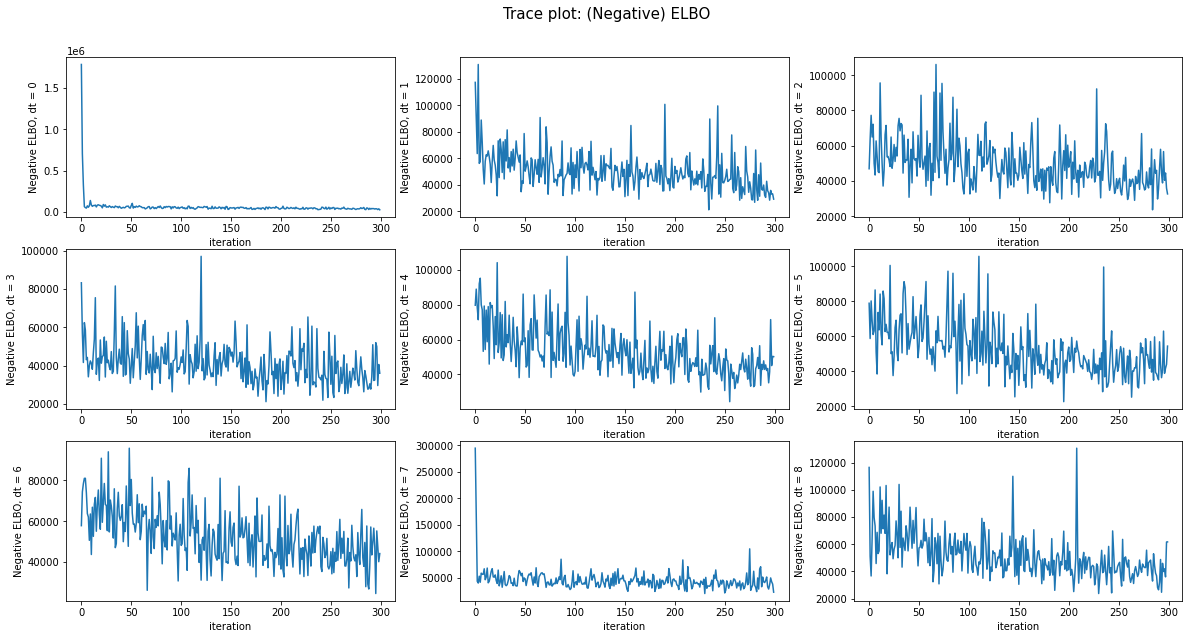

In [35]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(elbo_traces[t, :IT])), elbo_traces[t, :IT])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

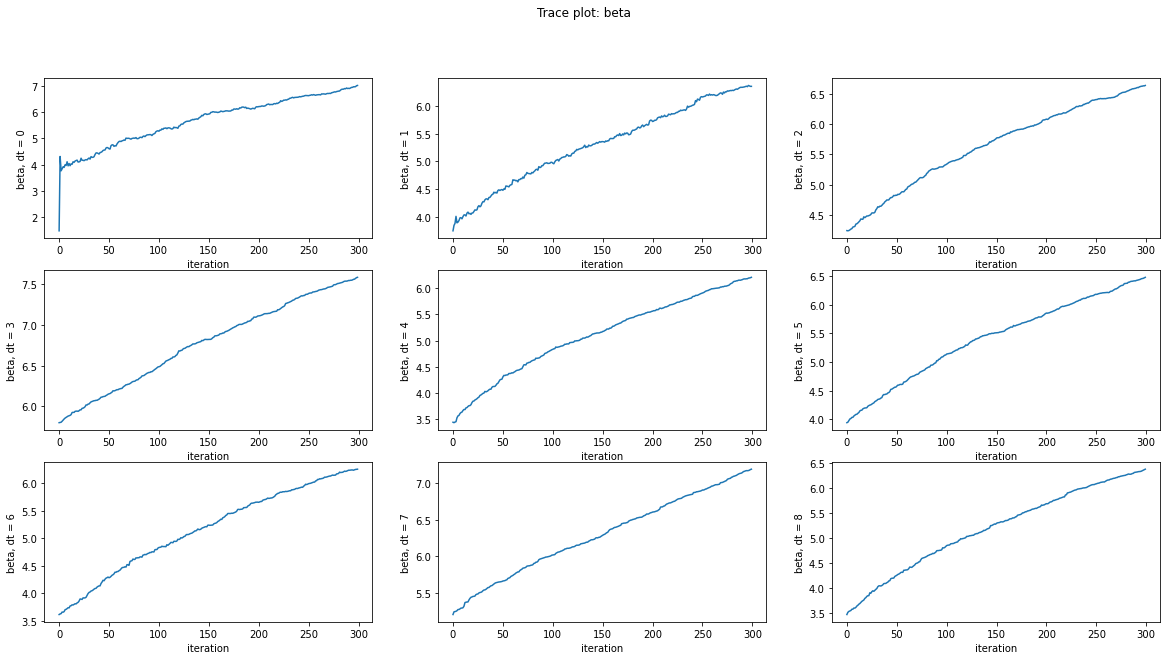

In [36]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(pars_traces[1, t, :IT])), pars_traces[1, t, :IT])
    ax.set_xlabel("iteration")
    ax.set_ylabel("beta, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: beta")
plt.show()

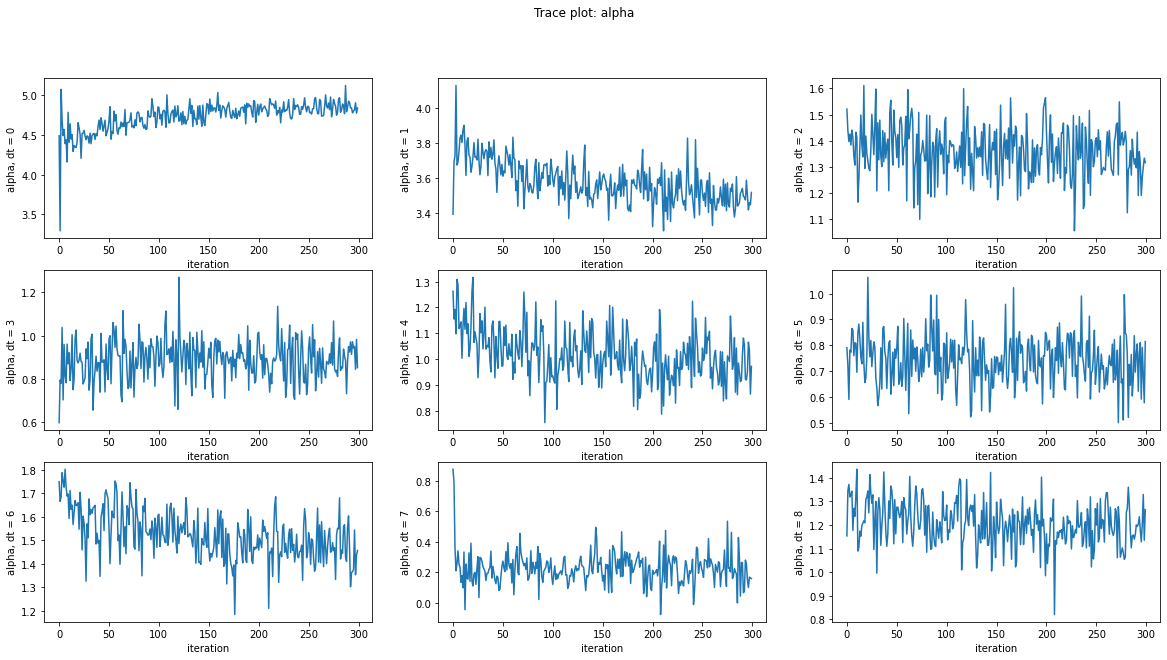

In [37]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(pars_traces[0, t, :IT])), pars_traces[0, t, :IT])
    ax.set_xlabel("iteration")
    ax.set_ylabel("alpha, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: alpha")
plt.show()

In [40]:
def g_posterior_moment(init, vi_alpha, vi_beta, t0, t1):
    """
        Obtain credible interval
            posterior mean and variance are computed based on the theory (using fitted variational parameter at each interval)
    """
    sigma = 1.
    pts = np.linspace(t0,t1,900)
    dt = pts[1:] - pts[:-1]
    
    mean = [init]
    var = list(map(lambda t: np.sqrt((sigma ** 2 / (2*vi_beta[0])) * (1 - np.exp(-2 * vi_beta[0] * t))), dt[:100]))
    
    k = 0
    for j in range(dt.shape[0]):
        if j % 100 == 0:
            beta = vi_beta[k]
            alpha = vi_alpha[k]
            k += 1
        mean.append(alpha + (mean[j] - alpha)*np.exp(-1 * beta * dt[j]))
        if (j % 100 == 0) and (j > 0):
            func = lambda t: np.sqrt((sigma ** 2 / (2*beta)) * (1 - np.exp(-2 * beta * t)))
            var += list(map(func, dt[j-100:j]))
    return np.array(mean), np.array(var)

In [41]:
pmean, pvar = g_posterior_moment(obs[0], vi_pars[0], vi_pars[1], 0, 6)

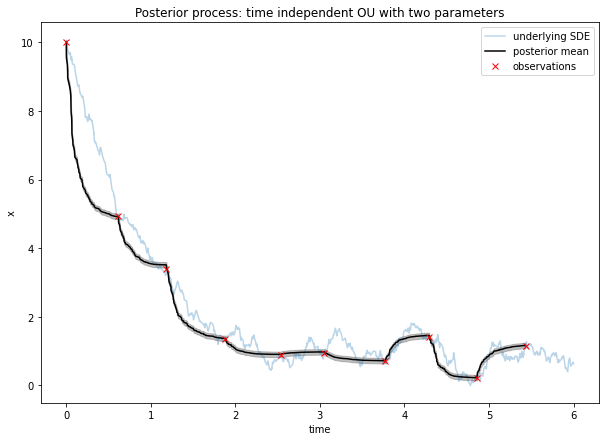

In [45]:
plt.figure(figsize=(10,7))
plt.title("Posterior process: time independent OU with two parameters")
plt.plot(true_sde.pts, true_sde.trj, alpha=0.3, label='underlying SDE')
plt.plot(true_sde.pts[:900], pmean, 'black', label='posterior mean')
plt.fill_between(true_sde.pts[:900], pmean - pvar, pmean + pvar, alpha=0.5, color='grey')
plt.plot(obs_time, obs, 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()